In [8]:
# !pip install --upgrade --user fastai torch torchvision torchaudio #--index-url https://download.pytorch.org/whl/cu116

  Obtaining dependency information for fastai from https://files.pythonhosted.org/packages/b4/44/25472496c58a9c4aa43465ae8daffb4452ebbe61b43342fe0f8a53ed836b/fastai-2.7.13-py3-none-any.whl.metadata
  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/6d/13/b5e8bacd980b2195f8a1741ce11cbb9146568607795d5e4ff510dcff1064/torch-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/84/eb/4f6483ae9094e164dc5b9b792e377f7d37823b0bedc3eef3193d416d2bb6/torchvision-0.16.0-cp310-cp310-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for torchaudio from https://files.pythonhosted.org/packages/31/52/3f76cf4364322db27ea1d6b32a7864b2d7a78a2c240d975b25783e262035/torchaudio-2.1.0-cp310-cp310-manylinux1_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 5.5 MB/s eta 0:00:00
  Obtaining dependency information for spacy<4 from https://fil

In [9]:
import torch
print(torch.cuda.is_available())

False


In [10]:
from fastai.collab import CollabDataLoaders, collab_learner
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import numpy as np

random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.random.manual_seed(random_seed)
torch.manual_seed(random_seed) # cpu  vars
torch.cuda.manual_seed_all(random_seed) # gpu 
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True  #needed
torch.backends.cudnn.benchmark = False

import warnings

In [11]:
%%bigquery df_blackfriday_data
select * from `blackfridayintelia.blackfriday.blackfriday`

Query is running:   0%|          |

Downloading:   0%|          |

## Data Processing

In [12]:
trainset, testset = train_test_split(df_blackfriday_data, random_state=random_seed, test_size=0.25)


In [13]:
ratings_dict = {'item': list(trainset.Product_ID),
                'user': list(trainset.User_ID),
                'rating': list((trainset.Purchase.pow(1/2)- 3.464)/15)}
ratings = pd.DataFrame(ratings_dict)

ratings_test_dict = {'item': list(testset.Product_ID),
                'user': list(testset.User_ID),
                'rating': list((testset.Purchase.pow(1/2) -3.464)/15)}
ratings_test = pd.DataFrame(ratings_test_dict)

In [22]:
ratings.describe()

,user,rating
count,4.125510e+05,412551.000000
mean,1.003032e+06,5.924891
std,1.727880e+03,1.813775
min,1.000001e+06,0.000007
25%,1.001522e+06,4.857179
50%,1.003080e+06,5.749405
75%,1.004480e+06,7.088751
max,1.006040e+06,10.088627


In [23]:
dls = CollabDataLoaders.from_df(ratings, bs=512, seed=random_seed)

## DL

In [15]:
learn = collab_learner(dls, n_factors=160, use_nn=True, y_range=(0, 10))
import warnings


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.920551,0.928266,00:14
1,0.838436,0.827121,00:14
2,0.776684,0.774904,00:14
3,0.704686,0.745418,00:13
4,0.627800,0.751769,00:13


In [16]:
learn.model

EmbeddingNN(
  (embeds): ModuleList(
    (0): Embedding(3594, 157)
    (1): Embedding(5891, 207)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=364, out_features=160, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=160, out_features=1, bias=True)
    )
    (2): fastai.layers.SigmoidRange(low=0, high=10)
  )
)

In [25]:
ratings_test

,item,user,rating
0,P00161042,1005387,6.874933
1,P00069042,1005831,6.768114
2,P00358342,1001842,4.277824
3,P00278642,1001381,2.725792
4,P00049542,1004404,6.408344
...,...,...,...
137512,P00117642,1004907,8.888033
137513,P00334242,1003916,8.161921
137514,P00267842,1004979,3.671772
137515,P00288342,1005779,6.389574


In [17]:
dl = learn.dls.test_dl(ratings_test, with_labels=True)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    aaa = learn.get_preds(dl=dl)
    aaa

testset['y'] = (testset['Purchase'].pow(1/2) -3.464)/15
testset['y_pred'] = [x.tolist()[0] for x in aaa[0]]

# testset['y_pred'] = testset['y_pred']*testset['y_pred']*225

from sklearn.metrics import mean_squared_error
from math import sqrt

print('Scaled RMSE', sqrt(mean_squared_error(testset['y'], testset['y_pred'])))


Scaled RMSE 0.8624311160502426


In [18]:
testset['Purchase_pred'] = (testset.y_pred*15 +3.464) * (testset.y_pred*15 +3.464)
print('RMSE on the original test set', sqrt(mean_squared_error(testset['Purchase'], testset['Purchase_pred'])))


RMSE on the original test set 2460.1524061340824


<Axes: title={'center': 'Recommendation - DL Model'}, xlabel='Purchase', ylabel='Purchase_pred'>

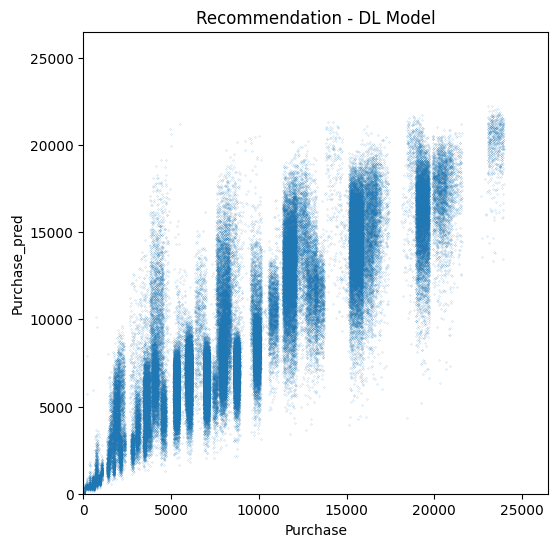

In [28]:
testset[['Purchase', 'Purchase_pred']].plot.scatter(x='Purchase', 
                                                    y='Purchase_pred', 
                                                    xlim=[0,26500], 
                                                    ylim=[0,26500], 
                                                    s=0.01, 
                                                    title='Recommendation - DL Model',
                                                    figsize=(6, 6))